In [ ]:
# default_exp experiment

# experiment
> Helper utils for track and manage Dl experimets with pytorch and fastai.

In [ ]:
# export
# hide
from fastai.basics import *
from experiment_utils.data_imagenette import *
from torchvision.models import *
from experiment_utils.utils import *
from experiment_utils.ranger import *

In [ ]:
#hide
# from nbdev.showdoc import *

# Optimiser dict

In [ ]:
# export
# Dictionary defaults optimizers
opt_dict = {'adam': {'func': optim.Adam,
                     'params': {'betas': (0.95, 0.99), 'eps': 1e-6}},
            'ranger': {'func': Ranger,
                       'params': {'betas': (0.95, 0.99), 'eps': 1e-6}}}

# Parameters

In [ ]:
# export
# data default parameters
data_params = {  'size': 128,
                 'fullsize': False,
                 'woof': 1,
                 'bs': 64,
                 'augm': 'min',
                 'workers': None,}

In [ ]:
# export
class ExperimentParameters:
    def __init__(self, data=data_params):
        self.exp_name:  str = 'noname'
        self.pipeline = [train]
        self.data = data
    # Learner part
        self.model     = partial(resnet18, num_classes=10)
#         self.model     = {'name': 'resnet50', 
#                           'params': {'num_classes':10}}
        self.loss_func = LabelSmoothingCrossEntropy
        self.metrics   = [accuracy]
        self.wd      = 1e-2
        self.bn_wd   = False
        self.true_wd = True
        self.mixup = 0.
    # train - FOC
        self.epochs     = 5
        self.lr         = 0.01
        self.div_factor = 10
        self.moms       = (0.95, 0.85)
        self.pct_start  = 0.3
        self.final_div  = None
    # optimizer
        self.opt_name = 'adam'
        self.set_opt(self.opt_name)
    # sched
        self.fc_start_pct = 0.72
        self.fc_lr_final_div = 1e2
        self.shift=0.1

    def set_opt(self, opt_name):
        self.opt_name = opt_name
        self.opt_func = opt_dict[self.opt_name]['func'] #, **opt_dict[self.opt_name]['params'])
#         self.opt_params = param_parser(self.opt_func)
        self.opt_params = opt_dict[self.opt_name]['params']
        self.opt_def_params = param_parser(self.opt_func)
    
        #         for k,v in self.data.items():
        #             setattr(self, k, v)
    
    def get_opt(self):
        return partial(self.opt_func, **self.opt_params)
        
    opt = property(get_opt, set_opt)
    
    
    def __repr__(self):
        return f"params: exp:{self.exp_name}"

In [ ]:
# export
p = ExperimentParameters()

In [ ]:
p

params: exp:noname

In [ ]:
p.opt

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.95, 0.99), eps=1e-06)

In [ ]:
p.opt_params

{'betas': (0.95, 0.99), 'eps': 1e-06}

In [ ]:
p.opt_def_params

{'lr': 0.001,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False}

In [ ]:
p.exp_name

'noname'

In [ ]:
# hide
p.opt_name
p.opt

functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [ ]:
p.opt_params

{'lr': 0.001,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False}

In [ ]:
p.data

{'size': 128,
 'fullsize': False,
 'woof': 1,
 'bs': 64,
 'augm': 'min',
 'workers': None}

In [ ]:
# hide
p.opt, p.opt_name, p.opt_params

(functools.partial(<class 'torch.optim.adam.Adam'>, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False),
 'adam',
 {'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False})

In [ ]:
p.opt = 'ranger'

In [ ]:
p.opt, p.opt_name, p.opt_params

(functools.partial(<class 'experiment_utils.ranger.Ranger'>, lr=0.001, alpha=0.5, k=6, N_sma_threshhold=5, betas=(0.95, 0.999), eps=1e-05, weight_decay=0),
 'ranger',
 {'lr': 0.001,
  'alpha': 0.5,
  'k': 6,
  'N_sma_threshhold': 5,
  'betas': (0.95, 0.999),
  'eps': 1e-05,
  'weight_decay': 0})

# Learner

In [ ]:
# export
def get_learner(p=p):
    data = get_data(**p.data)
    learn = Learner(data, p.model(),  
                opt_func=p.opt,
                metrics=p.metrics, 
                wd=p.wd, bn_wd=p.bn_wd, true_wd=p.true_wd,
                loss_func=p.loss_func())
    learn.p = p
    if learn.p.mixup: learn = learn.mixup(alpha=learn.p.mixup)

    return learn

In [ ]:
learn = get_learner()

In [ ]:
learn.p.data

{'size': 128,
 'fullsize': False,
 'woof': 1,
 'bs': 64,
 'augm': 'min',
 'workers': None}

In [ ]:
# hide
learn.data.path

PosixPath('/root/.fastai/data/imagewoof2')

# Experiment

In [ ]:
# export
class Experiment:
    def __init__(self, p=p):
        self.p = p
#         self.p.pipeline = [train]

    def get_learner(self):
        self.l = get_learner(self.p)    
     
    @property 
    def learn(self): 
        "Learner, same as l" 
        return self.l
       
    def lr_f(self, repeat_times=1, new_learner=True):
        for i in range(repeat_times):
            if new_learner or not hasattr(self, 'l'): self.get_learner()
            print(f"run {i+1} of {repeat_times}")
            lr_f(self.l)
            
    def train(self, repeat_times=1, new_learner=False):
        self.train_res = []
        self.train_rec = []
        for i in range(repeat_times):
            print(f"repeat {i+1} of {repeat_times}")
            if new_learner or not hasattr(self, 'l'): self.get_learner()
            for f in self.p.pipeline:
                f(self.l)
#             self.train_rec.append(self.l.recorder.get_state())
            self.train_res.append(e.l.recorder.metrics[-1][0].item()) # only first metric!
    
    def plot(self, plot_all=True):
        self.l.plot(plot_all)
    
    def __call__(self,repeat_times=1, new_learner=True):
        self.lr_list = listify(self.p.lr)
        num = len(self.lr_list)
        self.result = {}
        self.result_repr = {}
        for n, lr in enumerate(self.lr_list):
            self.p.lr = lr
            print(f"run {n+1} of {num}, lr {lr}")
            self.train(repeat_times, new_learner)
            self.result[str(lr)] = self.train_res
            res_repr = self.get_res_repr(lr)
            print(res_repr)
            print(20*'-')
            self.result_repr[str(lr)] = res_repr
        self.p.lr = self.lr_list
    
    def get_res_repr(self, lr):
        res_repr = f"{lr}: "
        if len(self.train_res)>1:
            arr = np.array(self.train_res)
            res_repr += f"mean {arr.mean():0.4f} std {arr.std():0.4f} -- "
        for i in self.train_res:
            res_repr += f"{i:0.4f}, "
        return res_repr
    
    def print_results(self):
        for i in self.result_repr:
            print(self.result_repr[i])

            
e = Experiment()

In [ ]:
# hide
# from fastcore.foundation import *

In [ ]:
# hide
# @patch_to(Experiment)
# def tst_f(Experiment):
#     print('test test')

In [ ]:
# hide
# e.tst_f()

In [ ]:
# hide 
# p.pipeline = [partial(train, show_graph=True), partial(plot, plot_all=True)]

In [ ]:
# hide
p.pipeline

[<function experiment_utils.utils.train(learn, show_graph=False)>]

In [ ]:
#hide
e.p.exp_name

'noname'

In [ ]:
# hide
p.lr = [0.001]
p.epochs = 1
p.pipelineline = [train_fc, plot]

In [ ]:
# hide
e()

run 1 of 1, lr 0.001
repeat 1 of 1
epochs: 1, lr: 0.0010, opt - ranger


epoch,train_loss,valid_loss,accuracy,time
0,2.117627,2.031286,0.292695,00:31


0.001: 0.2927, 
--------------------


In [ ]:
e.print_results()

0.001: 0.2927, 


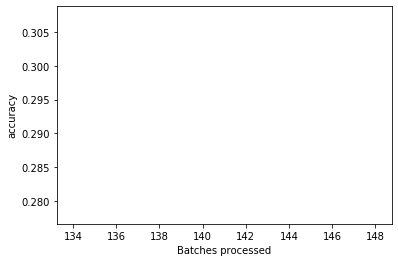

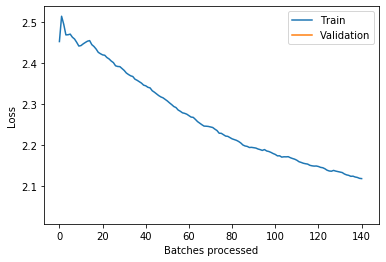

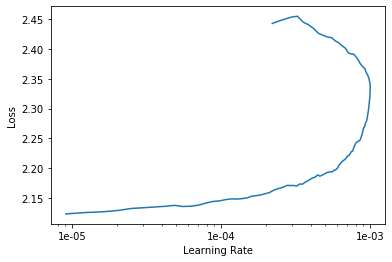

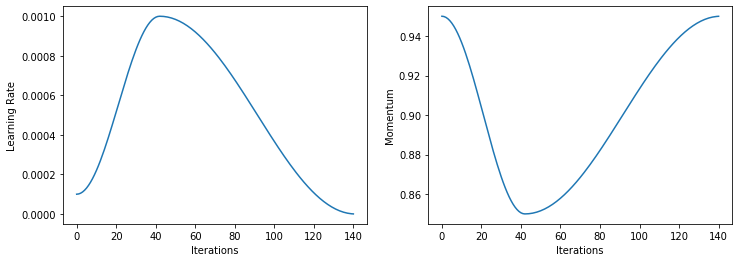

In [ ]:
e.plot()

In [ ]:
# hide
p.pipelineline = [train_fc, plot]

In [ ]:
# hide
# p.lr = [0.001, 0.002]
# e(2)

run 1 of 2, lr 0.001
repeat 1 of 2
epochs: 1, lr: 0.0010, opt - ranger


epoch,train_loss,valid_loss,accuracy,time
0,2.112166,2.022721,0.294477,00:31


repeat 2 of 2
epochs: 1, lr: 0.0010, opt - ranger


epoch,train_loss,valid_loss,accuracy,time
0,2.111911,2.025553,0.285060,00:31


0.001: mean 0.2898 std 0.0047 -- 0.2945, 0.2851, 
--------------------
run 2 of 2, lr 0.002
repeat 1 of 2
epochs: 1, lr: 0.0020, opt - ranger


epoch,train_loss,valid_loss,accuracy,time
0,2.081068,1.985271,0.320692,00:31


repeat 2 of 2
epochs: 1, lr: 0.0020, opt - ranger


epoch,train_loss,valid_loss,accuracy,time
0,2.071846,1.971292,0.327055,00:31


0.002: mean 0.3239 std 0.0032 -- 0.3207, 0.3271, 
--------------------


# end
by A. Yasyrev

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_experiment.ipynb.
Converted 01_utils.ipynb.
Converted 02_consistency.ipynb.
Converted 03_data_imagenette.ipynb.
Converted 50_ranger.ipynb.
Converted index.ipynb.
